### Nueral Machine Translation (NMT)


We are going to use the `Encoder` - `Decoder` achitecture. Think of it as an achitecture where an enocder maps the source-text to a "thought vector" that summarizes the text's contents, which is then input to the second part of the neural network that decodes the "thought vector" to the destination-text.

### Steps

* Consider the Danish text "der var engang" which translate to "once upon a time". 
* We first convert the entire data-set to integer-tokens so the text "der var engang" becomes [12, 54, 1097]. 
* Each of these integer-tokens is then mapped to an embedding-vector with e.g. 128 elements, so the integer-token 12 could for example become [0.12, -0.56, ..., 1.19] 
* These embedding vectoctors will be passed into a GRu with three layers.
The last GRU layer will output a single vector known as the "thought vector" that summarizes the contents of the source-text which is uses as the initial state of the GRU of the decoder.

* The destination-text "once upon a time" is padded with special markers "<sos>" and "<eos>" to indicate its beginning and end, so the sequence of integer-tokens becomes [2, 337, 640, 9, 79, 3].
* During training, the decoder will be given this entire sequence as input and the desired output sequence is [337, 640, 9, 79, 3] which is the same sequence but time-shifted one step.

* We are trying to teach the decoder to map the "thought vector" and the start-token "sos" (integer 2) to the next word "once" (integer 337), and then map the word "once" to the word "upon" (integer 640), and so forth.


### Imports



In [1]:
import os, math

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.__version__

'2.6.0'

### Data

We will be using the [Europarl dataset](http://www.statmt.org/europarl/) which contains pairs of most European laugauges. We are going to load the data as using the following helper function that was found [here](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/europarl.py).

In [14]:
import urllib.request
import tarfile, zipfile, sys


class Download:
  def __init__(self):
    pass
  def _print_download_progress(self, count, block_size, total_size):
      # Percentage completion.
      pct_complete = float(count * block_size) / total_size

      # Limit it because rounding errors may cause it to exceed 100%.
      pct_complete = min(1.0, pct_complete)

      # Status-message. Note the \r which means the line should overwrite itself.
      msg = "\r- Download progress: {0:.1%}".format(pct_complete)

      # Print it.
      sys.stdout.write(msg)
      sys.stdout.flush()

  def download(self, base_url, filename, download_dir):
      save_path = os.path.join(download_dir, filename)

      # Check if the file already exists, otherwise we need to download it now.
      if not os.path.exists(save_path):
          # Check if the download directory exists, otherwise create it.
          if not os.path.exists(download_dir):
              os.makedirs(download_dir)

          print("Downloading", filename, "...")

          # Download the file from the internet.
          url = base_url + filename
          file_path, _ = urllib.request.urlretrieve(url=url,
                                                    filename=save_path,
                                                    reporthook=self._print_download_progress)

          print(" Done!")


  def maybe_download_and_extract(self, url, download_dir):
      filename = url.split('/')[-1]
      file_path = os.path.join(download_dir, filename)
      if not os.path.exists(file_path):
          if not os.path.exists(download_dir):
              os.makedirs(download_dir)

          # Download the file from the internet.
          file_path, _ = urllib.request.urlretrieve(url=url,
                                                    filename=file_path,
                                                    reporthook=self._print_download_progress)

          print()
          print("Download finished. Extracting files.")

          if file_path.endswith(".zip"):
              # Unpack the zip-file.
              zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
          elif file_path.endswith((".tar.gz", ".tgz")):
              # Unpack the tar-ball.
              tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

          print("Done.")
      else:
          print("Data has apparently already been downloaded and unpacked.")

download = Download()

In [21]:
class Europal:
  data_dir = "data/europarl/"
  data_url = "http://www.statmt.org/europarl/v7/"

  def __init__(self):
    pass

  def maybe_download_and_extract(self, language_code="da"):
    url = self.data_url + language_code + "-en.tgz"
    download.maybe_download_and_extract(url=url, download_dir=self.data_dir)
  
  def load_data(self, english=True, language_code="da", start="", end=""):
    if english:
        # Load the English data.
        filename = "europarl-v7.{0}-en.en".format(language_code)
    else:
        # Load the other language.
        filename = "europarl-v7.{0}-en.{0}".format(language_code)

    path = os.path.join(self.data_dir, filename)

    with open(path, encoding="utf-8") as file:
      texts = [start + line.strip() + end for line in file]
    return texts


  

In [22]:
europal = Europal()

In [47]:
language_code='da'
mark_start = 'sos '
mark_end = ' eos'

In [24]:
europal.maybe_download_and_extract(language_code=language_code)

Data has apparently already been downloaded and unpacked.


### Now we can load the Sourc and the Target text from the dataset.

In [25]:
data_src = europal.load_data(english=False,
                              language_code=language_code)

data_trg = europal.load_data(english=True,
                              language_code=language_code,
                              start=mark_start,
                              end=mark_end
                              )

> We will be building a model that translate text from `danish` to `english`.


### Checking examples

In [26]:
data_src[0]

'Genoptagelse af sessionen'

In [27]:
data_trg[0]

'<sos> Resumption of the session <eos>'

### Error in Data

The data-set contains about 2 million sentence-pairs. Some of the data is incorrect. 

In [28]:
idx = 8002


In [29]:
data_src[idx]

'"Car il savait ce que cette foule en joie ignorait, et qu\'on peut lire dans les livres, que le bacille de la peste ne meurt ni ne disparaît jamais, qu\'il peut rester pendant des dizaines d\'années endormi dans les meubles et le linge, qu\'il attend patiemment dans les chambres, les caves, les malles, les mouchoirs et les paperasses, et que, peut-être, le jour viendrait où, pour le malheur et l\'enseignement des hommes, la peste réveillerait ses rats et les enverrait mourir dans une cité heureuse." (Thi han vidste det, som denne glade forsamling ikke vidste, og som man kan læse i bøger, at pestens bacille aldrig dør og aldrig forsvinder, at den kan sove i mange år i møbler og linned, at den venter tålmodigt i kamre, kældre, kufferter, lommetørklæder og papirer, og at den dag måske kommer, hvor pesten til menneskenes skade og oplysning vågner sine rotter og sender dem ud for at dø i en lykkelig by.)'

In [31]:
data_trg[idx]

'<sos> "He knew what those jubilant crowds did not know but could have learned from books: that the plague bacillus never dies or disappears for good; that it can lie dormant for years and years in furniture and linen-chests; that it bides its time in bedrooms, cellars, trunks, and bookshelves; and that perhaps the day would come when, for the bane and the enlightening of men, it would rouse up its rats again and send them forth to die in a happy city." <eos>'

### Tokenizer

We need to converts text into numbers. We are going to do the following:

1. convert text-words into so-called integer-tokens
2. we are going to padd the tokens so that they will have the same length.
3. convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

> _We are going to set the maximum number of words in the vocabulary to `10_000`. which means any word that lies outside the top `10_000` will be automatically conveted to unknown_. This is very important because some of the words just apppeared once in the corpus so they may not be that important.



In [19]:
num_words = 10_000

In [40]:
class TokenizerWrap(Tokenizer):

  def __init__(self, texts, padding, reverse=False, num_words =None):

    Tokenizer.__init__(self, num_words= num_words)
    self.fit_on_texts(texts)
    self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
    self.tokens = self.texts_to_sequences(texts)

    if reverse:
       self.tokens = [list(reversed(x)) for x in self.tokens]
       truncating = 'pre'
    else:
      truncating = 'post'

    self.num_tokens = [len(x) for x in self.tokens]
    self.max_tokens = np.mean(self.num_tokens)  + 2 * np.std(self.num_tokens)
    self.max_tokens = int(self.max_tokens)
    self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                           padding=padding,
                                           truncating=truncating)
    
  def token_to_word(self, token):
    return " " if token == 0 else self.index_to_word[token]

  def tokens_to_string(self, tokens):
    words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
    return  " ".join(words)

  def text_to_tokens(self, text, reverse=False, padding=False):
      tokens = self.texts_to_sequences([text])
      tokens = np.array(tokens) 
      if reverse:
        tokens = np.flip(tokens, axis=1)
        truncating = 'pre'
      else:
        truncating = 'post'

      if padding:
        return pad_sequences(tokens,
                                    maxlen=self.max_tokens,
                                    padding='pre',
                                    truncating=truncating)
      

### SRC language tokenizer

Now we are going to create the tokenizer of the `src` language.

> Note that we pad zeros at the beginning ``('pre')`` of the sequences. We also reverse the sequences of tokens because the research literature suggests that this might improve performance, because the last words seen by the encoder match the first words produced by the decoder, so short-term dependencies are supposedly modelled more accurately.

In [41]:
tokenizer_src = TokenizerWrap(texts=data_src,
                              padding='pre',
                              reverse=True,
                              num_words=num_words)

### TRG tokenizer for the destination language.
> Note that this tokenizer does not reverse the sequences and it pads zeros at the end ``('post')`` of the arrays.

In [42]:
tokenizer_trg = TokenizerWrap(texts=data_trg,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

> Note that the sequence-lengths are different for the source and destination languages. This is because texts with the same meaning may have different numbers of words in the two languages.

> Furthermore, we have made a compromise when tokenizing the original texts in order to save a lot of memory. This means we only truncate about 5% of the texts.

In [44]:
tokens_src = tokenizer_src.tokens_padded
tokens_trg = tokenizer_trg.tokens_padded
print(tokens_src.shape)
print(tokens_trg.shape)

(1968800, 47)
(1968800, 55)


### Start and end tokens

In [49]:
token_start = tokenizer_trg.word_index[mark_start.strip()]
token_end = tokenizer_trg.word_index[mark_end.strip()]

token_start, token_end

(2, 3)

### Example of Token Sequences

In [50]:
tokens_src[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       6108,    7, 5243], dtype=int32)

In [51]:
tokenizer_src.tokens_to_string(tokens_src[0])

'sessionen af genoptagelse'

In [53]:
tokens_trg[0]

array([   2, 4825,    4,    1, 1122,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [56]:
tokenizer_trg.tokens_to_string(tokens_trg[0])

'sos resumption of the session eos'

the original sentence in the dataset.

In [55]:
data_trg[0]

'<sos> Resumption of the session <eos>'

### Training data.

Now that the data-set has been converted to sequences of integer-tokens that are padded and truncated and saved in numpy arrays, we can easily prepare the data for use in training the neural network.

### Encoder inputs

The input to the encoder is merely the numpy array for the padded and truncated sequences of integer-tokens produced by the tokenizer:

In [57]:
encoder_input_data = tokens_src

### Decoder Inputs and Outputs

The input and output data for the decoder is identical, except shifted one time-step. We can use the same numpy array to save memory by slicing it, which merely creates different 'views' of the same data in memory.

In [58]:
tokens_trg

array([[   2, 4825,    4, ...,    0,    0,    0],
       [   2,   13, 2721, ...,    0,    0,    0],
       [   2,  404,   19, ...,    0,    0,    0],
       ...,
       [   2, 7773,    4, ...,    0,    0,    0],
       [   2,   13, 2721, ...,    0,    0,    0],
       [   2,    1,  954, ...,    0,    0,    0]], dtype=int32)

In [61]:
tokens_trg.shape

(1968800, 55)

In [62]:
decoder_input_data = tokens_trg[:, :-1]
decoder_input_data.shape

(1968800, 54)

In [64]:
decoder_output_data  = tokens_trg[:, 1: ]
decoder_output_data.shape

(1968800, 54)

> _These token-sequences are identical except they are shifted one time-step_.

In [65]:
decoder_input_data[0]

array([   2, 4825,    4,    1, 1122,    3,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [66]:
decoder_output_data[0]

array([4825,    4,    1, 1122,    3,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

If we use the tokenizer to convert these sequences back into text, we see that they are identical except for the first word which is 'sos' that marks the beginning of a text.

In [67]:
tokenizer_trg.tokens_to_string(decoder_input_data[idx])

'sos he knew what those did not know but could have learned from books that the never or for good that it can lie for years and years in and that it its time in and and that perhaps the day would come when for the and the of men it would up its'

In [68]:
tokenizer_trg.tokens_to_string(decoder_output_data[idx])

'he knew what those did not know but could have learned from books that the never or for good that it can lie for years and years in and that it its time in and and that perhaps the day would come when for the and the of men it would up its again'

### Creating a NN

### Encoder
First we will create an encoder, it maps sequence of integers to a thought vector. We are going to use the functional API from keras which is more flexible than the sequential api.

In [70]:
encoder_input = keras.layers.Input(shape=(None, ), name='encoder_input')

In [71]:
embedding_size = 128

encoder_embedding = keras.layers.Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='encoder_embedding')

Next we are going to create 3 GRU's. Note that on the last GRU we are not returning `sequences` and the state size of all these GRU's will be 512.

In [73]:
state_size = 512
encoder_gru1 = keras.layers.GRU(state_size, name='encoder_gru1',
                   return_sequences=True)
encoder_gru2 = keras.layers.GRU(state_size, name='encoder_gru2',
                   return_sequences=True)
encoder_gru3 = keras.layers.GRU(state_size, name='encoder_gru3',
                   return_sequences=False)

Connecting te encoder layers.

... we are going to create a helper function that will connect the layers of the encoder using the Functional API approach.

In [74]:
def connect_encoder():
  net = encoder_input
  net = encoder_embedding(net)
  net = encoder_gru1(net)
  net = encoder_gru2(net)
  net = encoder_gru3(net)
  return net # encoder outputs

> _Note how the encoder uses the normal output from its last GRU-layer as the "thought vector". Research papers often use the internal state of the encoder's last recurrent layer as the "thought vector". But this makes the implementation more complicated and is not necessary when using the GRU. But if you were using the LSTM instead then it is necessary to use the LSTM's internal states as the "thought vector" because it actually has two internal vectors, which we would need to initialize the two internal states of the decoder's LSTM units._

In [75]:
encoder_output = connect_encoder()

### Decoder

Create the decoder-part which maps the "thought vector" to a sequence of integer-tokens.

The decoder takes two inputs. First it needs the "thought vector" produced by the encoder which summarizes the contents of the input-text.

In [76]:
decoder_initial_state = keras.layers.Input(shape=(state_size,),
                              name='decoder_initial_state')

The decoder also needs a sequence of integer-tokens as inputs. During training we will supply this with a full sequence of integer-tokens e.g. corresponding to the text "sos once upon a time eos"

During inference when we are translating new input-texts, we will start by feeding a sequence with just one integer-token for "esos" which marks the beginning of a text, and combined with the "thought vector" from the encoder, the decoder will hopefully be able to produce the correct next word e.g. "once".

In [78]:
decoder_input = keras.layers.Input(shape=(None, ), name='decoder_input')

... the decoder embedding layer convers integer tokens to floating values between -1 and 1.

In [79]:
decoder_embedding = keras.layers.Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

We will then create 3 GRU layers of the decoder that will both return sequences.

> _Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence._

In [80]:
decoder_gru1 = keras.layers.GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = keras.layers.GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = keras.layers.GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

The GRU layers output a tensor with shape ``[batch_size, sequence_length, state_size]``, where each "word" is encoded as a vector of length ``state_size``. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

In [81]:
decoder_dense = keras.layers.Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

The decoder is built using the functional API of Keras, which allows more flexibility in connecting the layers e.g. to route different inputs to the decoder. This is useful because we have to connect the decoder directly to the encoder, but we will also connect the decoder to another input so we can run it separately.

In [82]:
def connect_decoder(initial_state):
  net = decoder_input
  net = decoder_embedding(net)
  net = decoder_gru1(net, initial_state=initial_state)
  net = decoder_gru2(net, initial_state=initial_state)
  net = decoder_gru3(net, initial_state=initial_state)

  out = decoder_dense(net)
  return out

### Connecting and creating a models

_First we connect the encoder directly to the decoder so it is one whole model that can be trained end-to-end. This means the initial-state of the decoder's GRU units are set to the output of the encoder_



In [84]:
decoder_output = connect_decoder(initial_state=encoder_output)

model_train = keras.Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output])

... then we create the encoder model serperately.

In [87]:
model_encoder = keras.Model(inputs=[encoder_input],
                            outputs=[encoder_output])


... then we create the model decoder alone as well.

In [88]:
decoder_output = connect_decoder(initial_state=decoder_initial_state)

model_decoder = keras.Model(inputs=[decoder_input, decoder_initial_state],
                      outputs=[decoder_output])

### Plotting the models

... train model

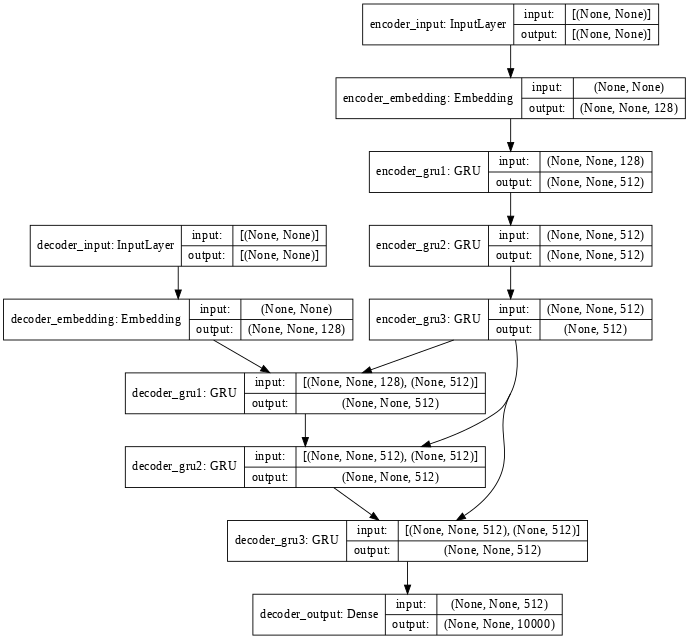

In [89]:
keras.utils.plot_model(model_train, dpi=64, show_shapes=True)

...encoder model

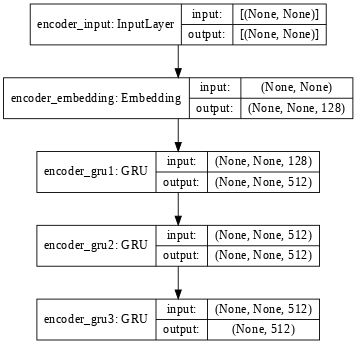

In [90]:
keras.utils.plot_model(model_encoder, dpi=64, show_shapes=True)

...decoder model

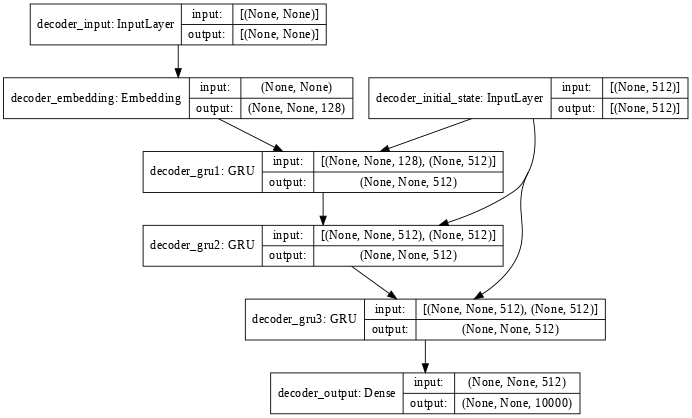

In [91]:
keras.utils.plot_model(model_decoder, dpi=64, show_shapes=True)

### Compile the Model

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.


However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 10000 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays.



In [94]:
model_train.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
                    loss='sparse_categorical_crossentropy')

### Callback functions


1. checkpoint


In [96]:
path_checkpoint = 'best-model-checkpoint.keras'
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True
                                      )

2. early stopping

In [97]:
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

In [98]:
callbacks = [
      callback_checkpoint,
      callback_early_stopping
]

### Trainning the model.

We wrap the data in named dicts so we are sure the data is assigned correctly to the inputs and outputs of the model.

In [99]:
x_data = {
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

y_data = {
    'decoder_output': decoder_output_data
}

Training this model, as single epoch will take aproximately an hour.

In [ ]:
model_train.fit(x=x_data,
                y=y_data,
                batch_size=128,
                epochs=10,
                validation_split=.005,
                callbacks=callbacks)

### Model inference

In [103]:
def translate(input_text, true_output_text=None):
  input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                reverse=True,
                                                padding=True)
  initial_state = model_encoder.predict(input_tokens)
  max_tokens = tokenizer_trg.max_tokens

  decoder_input_data = np.zeros(shape=(1, max_tokens), dtype=np.int)
  token_int = token_start
  output_text = ''
  count_tokens = 0
  while token_int != token_end and count_tokens < max_tokens:
     decoder_input_data[0, count_tokens] = token_int
     x_data = {
            'decoder_initial_state': initial_state,
            'decoder_input': decoder_input_data
     }
     decoder_output = model_decoder.predict(x_data)
     token_onehot = decoder_output[0, count_tokens, :]
     token_int = np.argmax(token_onehot)
     sampled_word = tokenizer_trg.token_to_word(token_int)
     output_text += " " + sampled_word
     count_tokens += 1
  output_tokens = decoder_input_data[0]
  print("Input text:")
  print(input_text)
  print()

  print("Translated text:")
  print(output_text)
  print()

  if true_output_text is not None:
    print("True output text:")
    print(true_output_text)
    print()

### Examples

We are going to use our train data.

In [104]:
idx = 3
translate(input_text=data_src[idx],
          true_output_text=data_trg[idx])

Input text:
De har udtrykt ønske om en debat om dette emne i løbet af mødeperioden.

Translated text:
 you have expressed a debate on this subject in the debate eos

True output text:
<sos> You have requested a debate on this subject in the course of the next few days, during this part-session. <eos>



In [105]:
idx = 4
translate(input_text=data_src[idx],
          true_output_text=data_trg[idx])

Input text:
I mellemtiden ønsker jeg - som også en del kolleger har anmodet om - at vi iagttager et minuts stilhed til minde om ofrene for bl.a. stormene i de medlemslande, der blev ramt.

Translated text:
 in the end of the day i would also like to ask you to remember the fact that we are talking about a number of member states including the victims of the disaster eos

True output text:
<sos> In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union. <eos>



from the user

In [106]:
translate(input_text="der var engang et land der hed Danmark",
          true_output_text='Once there was a country named Denmark')

Input text:
der var engang et land der hed Danmark

Translated text:
 there was a country which was even eos

True output text:
Once there was a country named Denmark



In [107]:
translate(input_text="Hvem spæner ud af en butik og tygger de stærkeste bolcher?",
          true_output_text="Who runs out of a shop and chews the strongest bon-bons?")

Input text:
Hvem spæner ud af en butik og tygger de stærkeste bolcher?

Translated text:
 who is a of the and the eos

True output text:
Who runs out of a shop and chews the strongest bon-bons?



### Conclusion

I did not train the model for even a single epoch, the model only train for aproximately 30 min but was able to pick up some words. To improve the model performance we may want to train the model for more than 10 epochs to get accurate results.

#### Credits.

* [Hvass-Labs](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb)